# Generate a PV diagram using PVExtractor following this tutorial:
#### https://learn.astropy.org/tutorials/PVDiagramPlotting.html

In [1]:
import pylab as plt
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patheffects as pe


# set so that these display properly on black backgrounds
#plt.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path, PathFromCenter

### First use the scattered light image to get the vector along which we'll generate the PV diagram

In [2]:
# load in the PS1 g-band image which we need to identify the disk's midplane

gband_file = '/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits'
gband = fits.open(gband_file)

wcs_gband = WCS(gband[0].header)
gband_data = gband[0].data
gband_header = gband[0].header

#gband_header

In [3]:
# then load in the 12CO data cube which is needed to obtain the velocities

spectral_cube = SpectralCube.read('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.velcor.fixVel.lsrk.im.image.fits')

spectral_cube = spectral_cube.with_spectral_unit(unit=u.km/u.s, rest_value=230.538*u.GHz, velocity_convention='radio')
spectral_cube._unit = u.Jy/u.beam

spectral_cube

VaryingResolutionSpectralCube with shape=(60, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   347.406190 deg:  347.457880 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    67.384148 deg:   67.404009 deg
 n_s:     60  type_s: VRAD      unit_s: km / s  range:      -13.626 km / s:       7.802 km / s

In [4]:
# define the centtral point of the vector (I got the coordinates from CASA)
ra_cen = 347.4323*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=20.*u.arcsec, angle=338*u.deg, sample=2, width=0.01*u.arcsec)

pvdiagram = extract_pv_slice(cube=spectral_cube, path=Path, spacing=1.)

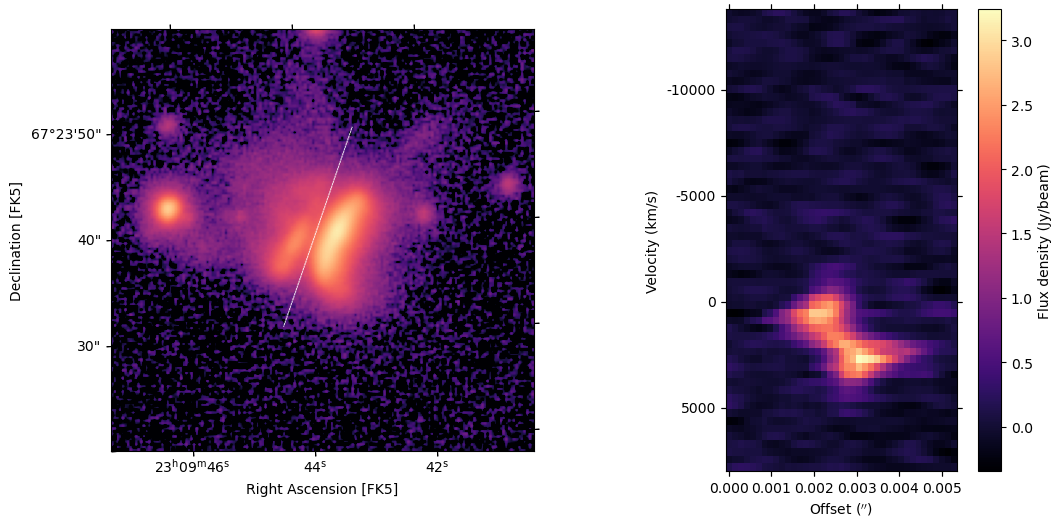

In [5]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_gband)

ax.imshow(gband_data, cmap='magma', norm=SymLogNorm(linthresh=1e1, linscale=0.001, vmin=-10, vmax=1e5))
Path.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)



# then show the PV diagram
ww = wcs.WCS(pvdiagram.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww)
im = ax.imshow(pvdiagram.data, cmap='magma')


#ax0 = ax.coords[0]
#ax0.set_format_unit(u.arcsec)
#ax1 = ax.coords[1]
#ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)
cb.set_label("Flux density (Jy/beam)")

ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)


#ax.set_ylim(23, 50)




## Repeat the same analysis but now compute the PV diagram along the 12CO channel map

In [6]:
# load in the PS1 g-band image which we need to identify the disk's midplane

mom0_file = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.velcor.fixVel.lsrk.im.image_M0.fits'
mom0 = fits.open(mom0_file)

wcs_mom0 = WCS(mom0[0].header)
mom0_data = mom0[0].data
mom0_header = mom0[0].header



In [7]:
### Now adjust the right ascension such that it aligns with the "major axis" of the 12CO emission

# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4318*u.deg 
dec_cen = 67.3942*u.deg 

len_slit = 22.*u.arcsec
width_slit = 6*u.arcsec
PA_slit = 342.*u.deg

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# sample : How many points to sample along the path. By default, this is 2 (the two end points)
# width : The width of the path
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=len_slit, angle=PA_slit, sample=2, width=width_slit)

# spacing gives the separation between these points in pixels; we finely sampled by picking one-pixel spacing.
pvdiagram2 = extract_pv_slice(cube=spectral_cube, path=Path2, spacing=1.)
pvdiagram2.writeto("PV_diagram_12CO.fits", overwrite=True)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


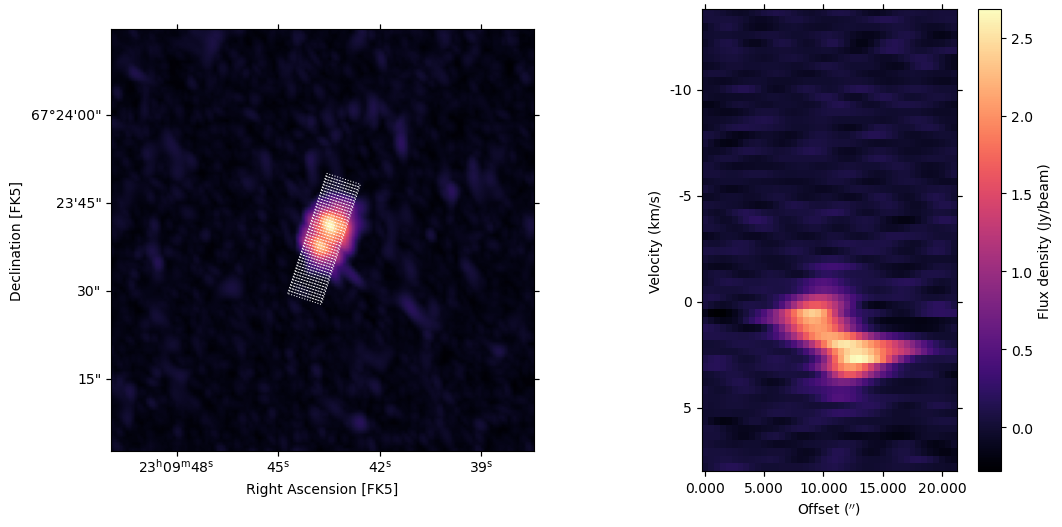

In [8]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_mom0)

ax.imshow(spectral_cube.max(axis=0).value, cmap='magma')
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)


# then show the PV diagram
ww2 = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww2)
im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)

v_sys = 1.6*u.km/u.s # got this value from eddy
x_mid = 11. #arcsec; length of the vector is 18 arcsec

#ax.set_ylim(23, 50)

## Now overplot the Keplerian velocity profile for different disk masses

In [9]:
### First define Keplerian velocity

import astropy.constants as const
import astropy.units as u

def kepler(mass, radius, distance, inclination):#, PA=342.):
    """
    mass in solar masses
    radius in arcsec
    distance in pc
    inclination in degrees
    """
    G = const.G
    mass *= u.Msun
    physical_radius = (radius*distance)*u.au
    
    return np.sqrt(G*mass/physical_radius).to(u.km/u.s)*np.sin(inclination*u.deg)#*np.cos(PA*u.deg)

In [10]:
pvdiagram2.header['CRVAL2']

7802.4219347786

In [11]:
# get pixel scales
pos_zero = pvdiagram2.header['CRVAL1'] # 0 deg
vel_zero = pvdiagram2.header['CRVAL2']/1000. # 7.8 km/s #  velocity in first channel

pos_pixscale = pvdiagram2.header['CDELT1']*60.*60. # arcsec per pixel
vel_pixscale = pvdiagram2.header['CDELT2']/1000. #-0.36319867699999997 km/s per pixel

pos_offset = pos_zero/pos_pixscale
vel_offset = vel_zero/vel_pixscale

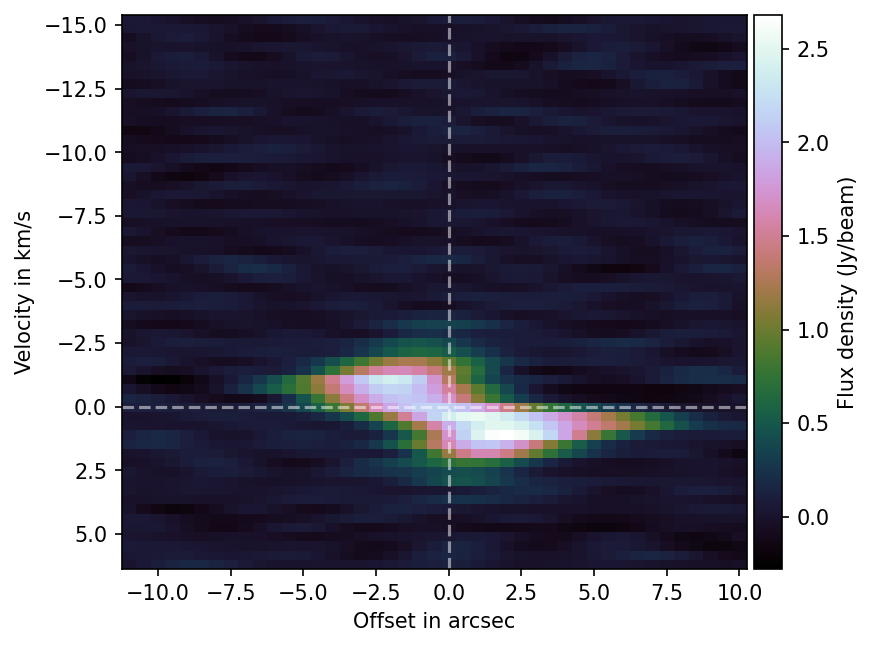

In [17]:
v_sys = 1.6 #u.km/u.s # got this value from eddy
pos_mid = len_slit.value/2. #arcsec; 

vel_arr = np.linspace(0,pvdiagram2.data.shape[1]-1,pvdiagram2.data.shape[1])*pos_pixscale + pos_zero - pos_mid 
pos_arr = np.linspace(0,pvdiagram2.data.shape[0]-1,pvdiagram2.data.shape[0])*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

plt.figure(dpi=150)

plt.pcolormesh(xi, yi, zi.reshape(yi.shape), cmap='cubehelix')

plt.gca().invert_yaxis()

plt.xlabel('Offset in arcsec')
plt.ylabel('Velocity in km/s')

# rainbow_r colormap starts at red
masses = np.arange(1,5,1)
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(masses)))
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
#for el in range(len(masses)):
#    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value+v_sys, c=colors[el], alpha=0.6, lw=2)
#    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value+v_sys, c=colors[el], alpha=0.6, lw=2)

plt.axhline(0, c='white', ls='--', alpha=0.5)
plt.axvline(0, c='white', ls='--', alpha=0.5)


cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=10)


This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


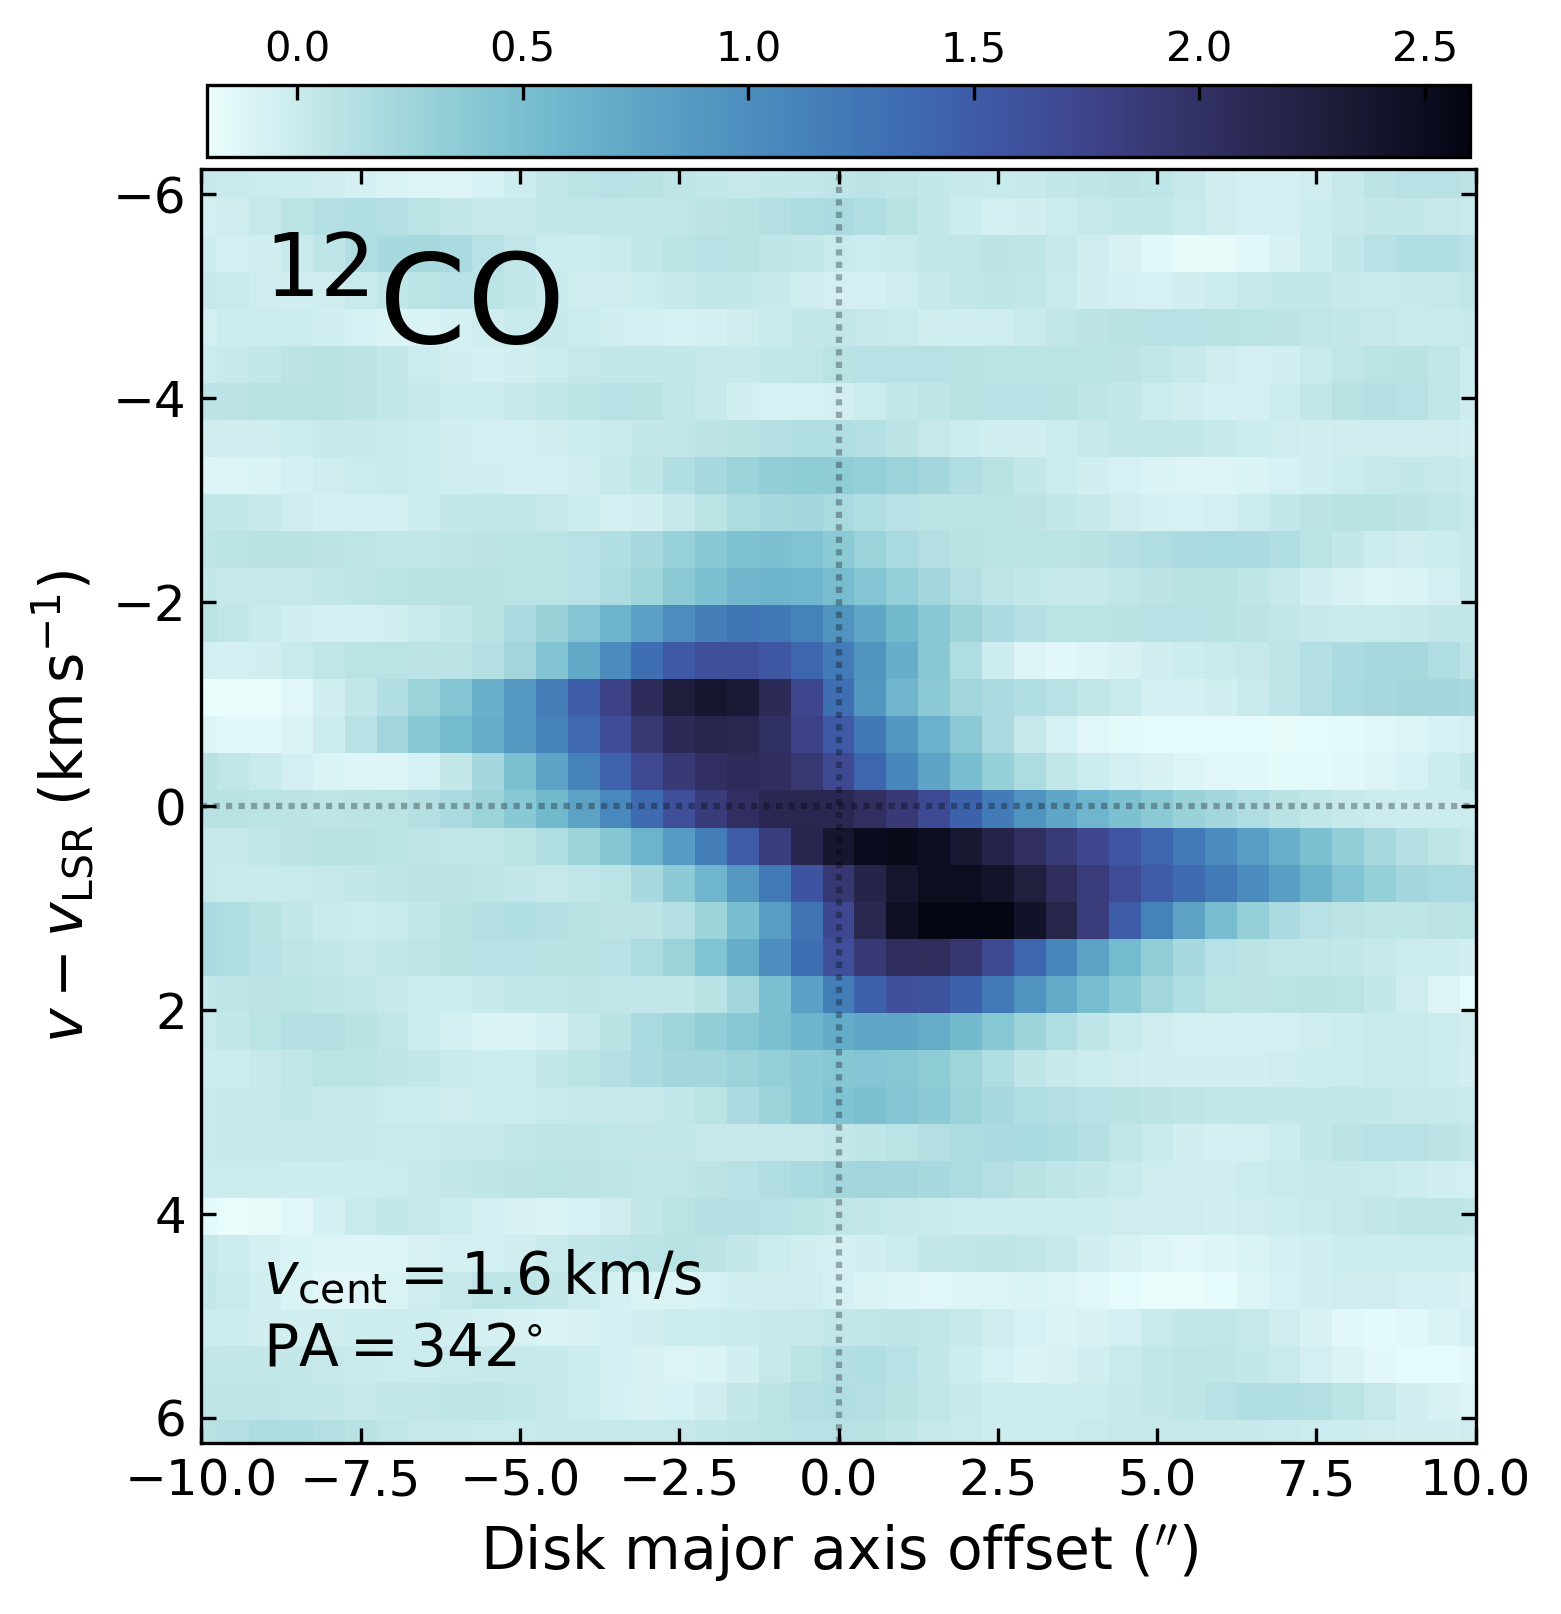

In [23]:
fig = plt.figure(layout="constrained", dpi=300)
fig.subplots_adjust(wspace=0.05)

gs = GridSpec(1, 1, figure=fig)
ax2 = fig.add_subplot(gs[0, 0])

vmin, vmax = -0.2, 2.6

### PV diagram
v_sys = 1.6 #u.km/u.s # got this value from eddy
pos_mid = len_slit.value/2. #arcsec; 

vel_arr = np.linspace(0,pvdiagram2.data.shape[1]-1,pvdiagram2.data.shape[1])*pos_pixscale + pos_zero - pos_mid 
pos_arr = np.linspace(0,pvdiagram2.data.shape[0]-1,pvdiagram2.data.shape[0])*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=color_table, linewidth=0,rasterized=True, vmin=vmin, vmax=vmax)

ax2.invert_yaxis()

ax2.set_xlabel("Disk major axis offset ($''$)", fontsize=14)
ax2.set_ylabel(r"$v-v_\mathrm{LSR}$ (km$\,\mathrm{{s}}^{{-1}}$)", fontsize=14)

ax2.axvline(0, c='black', ls=(0, (1, 1)), alpha=0.3)
ax2.axhline(0, c='black', ls=(0, (1, 1)), alpha=0.3)

ax2.set_ylim(6.25,-6.25)
ax2.set_xlim(10, -10)

ax2.yaxis.set_label_position("left")
#ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='both', direction="in", left=True, right=True, top=True, bottom=True, color='black', labelsize=12)

ax2.set_aspect(1.6)

#ax2.set_xticks(np.arange(-8,10,2), labels=np.arange(-8,10,2), fontsize=14)
#ax2.set_xticks([-4.4,-6.4, -8.5, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)
ax2.invert_xaxis()

# rainbow_r colormap starts at red
#cmr.neon
masses = np.arange(2,5,1)
colors = ['hotpink', 'hotpink', 'hotpink', 'hotpink', 'hotpink']
radii = np.linspace(0,20,1000) #arcsec

linestyles = [(0, (5, 1)), '-', (0, (1, 1))]
linewidths = [1.5,2.5,1.5]
 
cb_ax = fig.add_axes([0.171, 1., 0.658, 0.05]) #right, top, length, thickness, 
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='in')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('', fontsize=14, labelpad=-50)

#cb = fig.colorbar(im, ax=ax2, orientation='horizontal', pad=-10)
#cb.set_label(label='Flux density $(\mathrm{Jy\,beam}^{-1}$)', fontsize=13)
fig.text(0.2,0.87, s='$^{12}$CO', c='black', size=30)
fig.text(0.2,0.21, s=r'$v_\mathrm{{cent}}={0}\,\mathrm{{km/s}}$'.format(v_sys), c='black', size=14)
fig.text(0.2,0.16, s=r'PA$=342^{{\circ}}$', c='black', size=14)
#fig.text(0.2,0.16, s=r'$d=370$ pc', c='black', size=14)



#fig.tight_layout()

fig.savefig('../plots/paper_plots/pv_diagram_12CO_small_2.pdf', bbox_inches='tight')


## Get the pixel scales of the PV diagram

In [24]:
from astropy import wcs

# x-axis = offset in deg
# y-axis = velocity in m/s
ww2 = wcs.WCS(pvdiagram2)

wcs.utils.proj_plane_pixel_scales(ww2)
## 0.5 arcsec per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60)
x_pixelscale_arcsec = wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60
x_pixelscale_deg = wcs.utils.proj_plane_pixel_scales(ww2)[0]

## km/s per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[1]/1000)

0.50000000000004
0.36318654610158
